# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Keras / Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '21'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedice"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 265513)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 16:33:46 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    ssi  = xr.open_dataset(fname).ssi.values
    q_s  = xr.open_dataset(fname).q_rimedice.values
    num_s  = xr.open_dataset(fname).n_rimedice.values
    rime_s = xr.open_dataset(fname).rime_rimedice.values
    rvol_s = xr.open_dataset(fname).rvol_rimedice.values
    liq_s  = xr.open_dataset(fname).liq_rimedice.values
    # process rates
    depo_mass = xr.open_dataset(fname).depo_rimedice_mass.values   
    # normalize with ssi
    depo_mass = np.where(ssi>1e-4,depo_mass/ssi,np.nan)
    # values of ssi above 1e-2 are mixed-phase and at water saturation
    depo_mass = np.where(ssi<1e-2,depo_mass,np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # remove melting zone
    depo_mass = np.where(liq_s>q_min,np.nan,depo_mass)      
    # transform everything in log space
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*q_s)
    num_s  = np.log(num_s, where=num_s>n_min, out=np.nan*q_s)
    rime_s = np.log(rime_s, where=rime_s>q_min, out=np.nan*q_s)
    rvol_s = np.log(rvol_s, where=rvol_s>q_min, out=np.nan*q_s)
    depo_mass = np.log(depo_mass, where=depo_mass>p_min, out=np.nan*depo_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, num_s, rime_s, rvol_s, temp, ssi, rho, depo_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'num_s', 'rime_s', 'rvol_s', 'temp', 'ssi', 'rho', 'depo_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s          num_s         rime_s         rvol_s  \
count  101010.000000  101010.000000  101010.000000  101010.000000   
mean      -11.832782       7.514408     -12.845075     -18.163734   
std         2.495256       2.488119       2.664465       2.723895   
min       -23.023455      -5.665245     -24.978554     -30.264460   
25%       -13.432956       6.056005     -14.620120     -19.965889   
50%       -11.833461       7.598600     -12.906244     -18.226142   
75%       -10.025181       9.201292     -10.949503     -16.239538   
max        -5.603539      15.796070      -6.025973     -11.201185   

                temp            ssi            rho      depo_mass  
count  101010.000000  101010.000000  101010.000000  101010.000000  
mean      263.746490       0.004431       0.990333     -15.344179  
std         6.973869       0.002364       0.113585       2.478252  
min       246.210007       0.000200       0.721000     -31.064690  
25%       258.260010       0.002700       0.899000     -16.870964  
50%       264.869995       0.003500       0.998000     -15.308134  
75%       269.809998       0.006300       1.081000     -13.593647  
max       273.149994       0.009900       1.286000      -4.956147

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s     num_s     rime_s     rvol_s        temp     ssi    rho  \
26 -11.291623  7.628566 -13.265656 -18.477686  267.700012  0.0098  1.070   
31 -11.306888  7.597998 -13.279251 -18.498859  268.070007  0.0098  1.077   
32 -11.310474  7.592013 -13.282825 -18.504030  268.140015  0.0098  1.078   
61 -10.881495  7.528923 -11.960542 -17.154438  270.679993  0.0098  1.125   
78 -10.681974  7.588830 -11.511227 -16.676641  272.350006  0.0078  1.156   

    depo_mass  
26 -14.938697  
31 -14.943915  
32 -14.610229  
61 -14.147161  
78 -14.459165

In [11]:
dataset_train.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  70674.000000  70674.000000  70674.000000  70674.000000  70674.000000   
mean     -11.834658      7.510656    -12.847550    -18.166565    263.757111   
std        2.498972      2.493867      2.669209      2.728748      6.969425   
min      -23.023455     -5.665245    -24.976513    -30.264460    246.210007   
25%      -13.431133      6.047780    -14.615564    -19.964038    258.279999   
50%      -11.838185      7.600878    -12.906688    -18.227543    264.869995   
75%      -10.016875      9.209827    -10.940717    -16.228896    269.820007   
max       -5.603539     15.796070     -6.025973    -11.201185    273.149994   

                ssi           rho     depo_mass  
count  70674.000000  70674.000000  70674.000000  
mean       0.004429      0.990546    -15.346436  
std        0.002365      0.113432      2.482302  
min        0.000200      0.721000    -28.789536  
25%        0.002700      0.900000    -16.875981  
50%        0.003500      0.999000    -15.305533  
75%        0.006300      1.081000    -13.594065  
max        0.009900      1.286000     -5.174501

In [12]:
dataset_test.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  15212.000000  15212.000000  15212.000000  15212.000000  15212.000000   
mean     -11.827418      7.526005    -12.834676    -18.154163    263.787842   
std        2.497770      2.486995      2.657619      2.718940      6.989491   
min      -22.980114     -5.663198    -23.680105    -29.384850    246.240005   
25%      -13.432036      6.084596    -14.613640    -19.961666    258.260010   
50%      -11.803185      7.616013    -12.897840    -18.213139    264.970001   
75%      -10.035112      9.188688    -10.981195    -16.276508    269.859985   
max       -5.674379     15.782987     -6.099495    -11.276195    273.149994   

                ssi           rho     depo_mass  
count  15212.000000  15212.000000  15212.000000  
mean       0.004417      0.990818    -15.334230  
std        0.002357      0.114185      2.475528  
min        0.000200      0.726000    -28.481848  
25%        0.002700      0.900000    -16.851704  
50%        0.003500      0.999000    -15.283704  
75%        0.006300      1.082000    -13.593634  
max        0.009900      1.279000     -5.298781

In [13]:
dataset_val.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  15124.000000  15124.000000  15124.000000  15124.000000  15124.000000   
mean     -11.829417      7.520269    -12.843975    -18.160126    263.655243   
std        2.475423      2.462341      2.649257      2.706267      6.978605   
min      -22.979254     -5.428563    -24.978554    -30.200010    246.220001   
25%      -13.440934      6.064046    -14.638146    -19.976188    258.117493   
50%      -11.841812      7.576661    -12.909068    -18.234160    264.799988   
75%      -10.052806      9.162790    -10.960262    -16.257630    269.730011   
max       -5.708755     15.704442     -6.134873    -11.312355    273.149994   

                ssi           rho     depo_mass  
count  15124.000000  15124.000000  15124.000000  
mean       0.004455      0.988849    -15.343639  
std        0.002368      0.113688      2.462137  
min        0.000200      0.725000    -31.064690  
25%        0.002700      0.897000    -16.869047  
50%        0.003500      0.996000    -15.341820  
75%        0.006300      1.080000    -13.592912  
max        0.009900      1.286000     -4.956147

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  66490.000000  66490.000000  66490.000000  66490.000000  66490.000000   
mean     -11.751868      7.619219    -12.773414    -18.079433    263.189178   
std        2.396410      2.369090      2.590049      2.640610      6.788493   
min      -19.993015     -1.894723    -22.927546    -28.019245    246.210007   
25%      -13.401614      6.101954    -14.580965    -19.920950    257.829987   
50%      -11.800394      7.669612    -12.867663    -18.181152    264.200012   
75%       -9.964842      9.281334    -10.897591    -16.173450    269.040009   
max       -5.603539     15.796070     -6.025973    -11.201185    273.000000   

                ssi           rho     depo_mass  
count  66490.000000  66490.000000  66490.000000  
mean       0.004523      0.981407    -15.258771  
std        0.002318      0.109975      2.371593  
min        0.001400      0.721000    -24.454323  
25%        0.002700      0.894000    -16.840491  
50%        0.003500      0.988000    -15.259085  
75%        0.006300      1.069000    -13.559780  
max        0.009900      1.283000     -5.174501

In [17]:
dataset_test.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  14288.000000  14288.000000  14288.000000  14288.000000  14288.000000   
mean     -11.738130      7.639945    -12.752995    -18.059156    263.204620   
std        2.387419      2.350505      2.572123      2.623790      6.805782   
min      -19.959288     -1.574553    -22.926729    -28.017345    246.240005   
25%      -13.395256      6.153014    -14.572392    -19.913158    257.787506   
50%      -11.765382      7.694142    -12.843256    -18.161244    264.290009   
75%       -9.987576      9.267878    -10.926292    -16.213174    269.019989   
max       -5.674379     15.782987     -6.099495    -11.276195    273.000000   

                ssi           rho     depo_mass  
count  14288.000000  14288.000000  14288.000000  
mean       0.004514      0.981381    -15.238242  
std        0.002310      0.110594      2.357559  
min        0.001400      0.726000    -23.869316  
25%        0.002800      0.893000    -16.802333  
50%        0.003500      0.989000    -15.226812  
75%        0.006300      1.070000    -13.549140  
max        0.009900      1.279000     -5.298781

### Pairplot

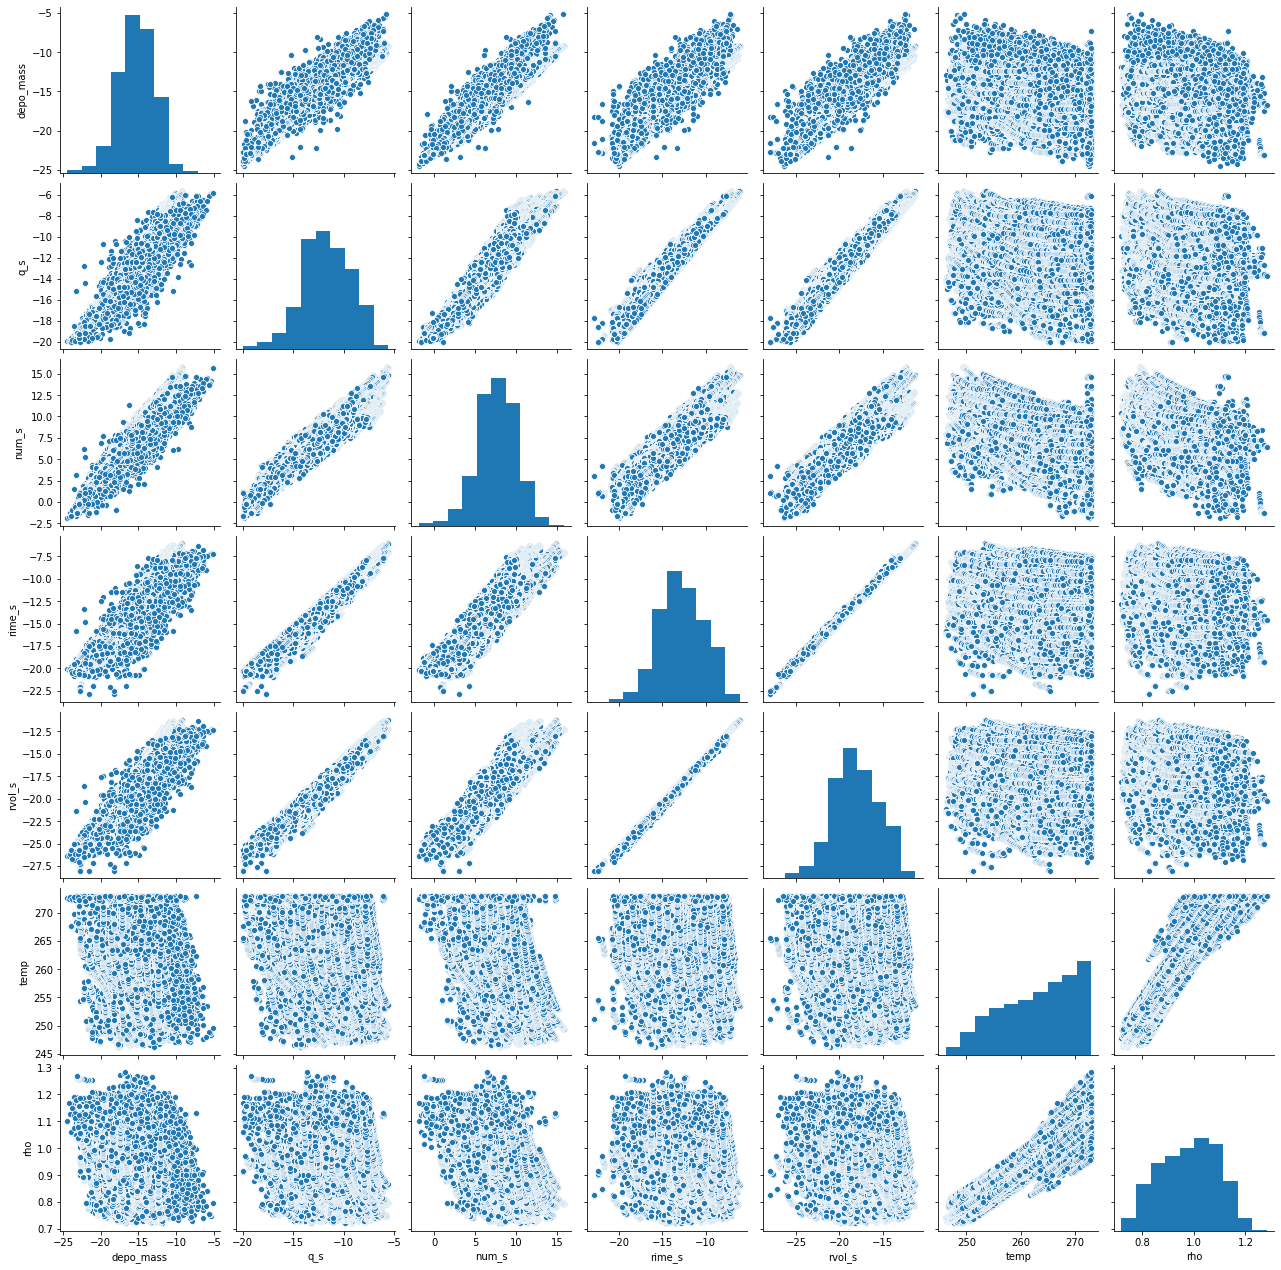

In [18]:
sns.pairplot(dataset_train[["depo_mass","q_s","num_s","rime_s","rvol_s","temp","rho"]], diag_kind="hist")

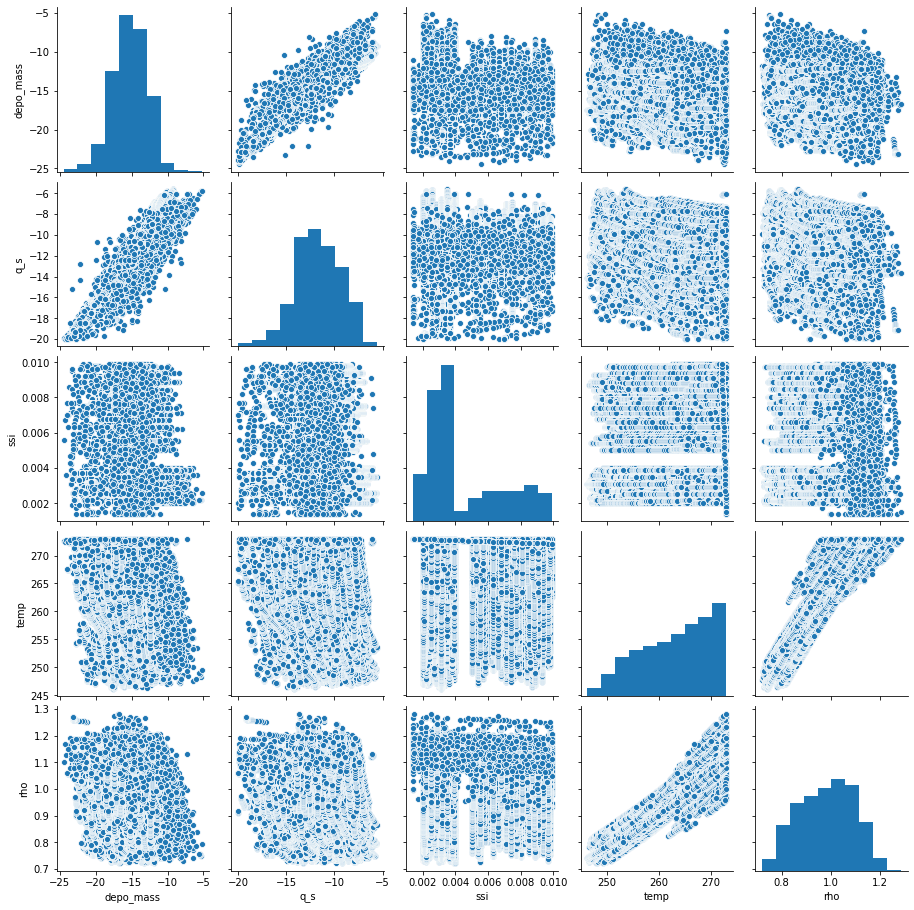

In [19]:
sns.pairplot(dataset_train[["depo_mass","q_s","ssi","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [20]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [21]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [22]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [23]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)

In [24]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)

In [25]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)

In [26]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("depo_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s     66490.0 -11.751868  2.396410 -19.993015 -13.401614 -11.800394   
num_s   66490.0   7.619219  2.369090  -1.894723   6.101954   7.669612   
rime_s  66490.0 -12.773414  2.590049 -22.927546 -14.580965 -12.867663   
rvol_s  66490.0 -18.079433  2.640610 -28.019245 -19.920950 -18.181152   

              75%        max  
q_s     -9.964842  -5.603539  
num_s    9.281334  15.796070  
rime_s -10.897591  -6.025973  
rvol_s -16.173450 -11.201185

In [27]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("depo_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_s     66490.0  -11.751868  2.396410  -19.993015  -13.401614  -11.800394   
num_s   66490.0    7.619219  2.369090   -1.894723    6.101954    7.669612   
rime_s  66490.0  -12.773414  2.590049  -22.927546  -14.580965  -12.867663   
rvol_s  66490.0  -18.079433  2.640610  -28.019245  -19.920950  -18.181152   
temp    66490.0  263.189178  6.788493  246.210007  257.829987  264.200012   
rho     66490.0    0.981407  0.109975    0.721000    0.894000    0.988000   

               75%         max  
q_s      -9.964842   -5.603539  
num_s     9.281334   15.796070  
rime_s  -10.897591   -6.025973  
rvol_s  -16.173450  -11.201185  
temp    269.040009  273.000000  
rho       1.069000    1.283000

In [28]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("depo_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s     66490.0  -11.751868  2.396410  -19.993015  -13.401614  -11.800394   
num_s   66490.0    7.619219  2.369090   -1.894723    6.101954    7.669612   
rime_s  66490.0  -12.773414  2.590049  -22.927546  -14.580965  -12.867663   
rvol_s  66490.0  -18.079433  2.640610  -28.019245  -19.920950  -18.181152   
temp    66490.0  263.189178  6.788493  246.210007  257.829987  264.200012   
rho     66490.0    0.981407  0.109975    0.721000    0.894000    0.988000   

               75%         max  
q_s      -9.964842   -5.603539  
num_s     9.281334   15.796070  
rime_s  -10.897591   -6.025973  
rvol_s  -16.173450  -11.201185  
temp    269.040009  273.000000  
rho       1.069000    1.283000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = ['depo_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_labels.describe()

depo_mass
count  66490.000000
mean     -15.258771
std        2.371593
min      -24.454323
25%      -16.840491
50%      -15.259085
75%      -13.559780
max       -5.174501

In [33]:
train_dataset1.describe()

q_s         num_s        rime_s        rvol_s
count  66490.000000  66490.000000  66490.000000  66490.000000
mean     -11.751868      7.619219    -12.773414    -18.079433
std        2.396410      2.369090      2.590049      2.640610
min      -19.993015     -1.894723    -22.927546    -28.019245
25%      -13.401614      6.101954    -14.580965    -19.920950
50%      -11.800394      7.669612    -12.867663    -18.181152
75%       -9.964842      9.281334    -10.897591    -16.173450
max       -5.603539     15.796070     -6.025973    -11.201185

In [34]:
train_dataset2.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  66490.000000  66490.000000  66490.000000  66490.000000  66490.000000   
mean     -11.751868      7.619219    -12.773414    -18.079433    263.189178   
std        2.396410      2.369090      2.590049      2.640610      6.788493   
min      -19.993015     -1.894723    -22.927546    -28.019245    246.210007   
25%      -13.401614      6.101954    -14.580965    -19.920950    257.829987   
50%      -11.800394      7.669612    -12.867663    -18.181152    264.200012   
75%       -9.964842      9.281334    -10.897591    -16.173450    269.040009   
max       -5.603539     15.796070     -6.025973    -11.201185    273.000000   

                rho  
count  66490.000000  
mean       0.981407  
std        0.109975  
min        0.721000  
25%        0.894000  
50%        0.988000  
75%        1.069000  
max        1.283000

In [35]:
train_dataset3.describe()

q_s         num_s        rime_s        rvol_s          temp  \
count  66490.000000  66490.000000  66490.000000  66490.000000  66490.000000   
mean     -11.751868      7.619219    -12.773414    -18.079433    263.189178   
std        2.396410      2.369090      2.590049      2.640610      6.788493   
min      -19.993015     -1.894723    -22.927546    -28.019245    246.210007   
25%      -13.401614      6.101954    -14.580965    -19.920950    257.829987   
50%      -11.800394      7.669612    -12.867663    -18.181152    264.200012   
75%       -9.964842      9.281334    -10.897591    -16.173450    269.040009   
max       -5.603539     15.796070     -6.025973    -11.201185    273.000000   

                rho  
count  66490.000000  
mean       0.981407  
std        0.109975  
min        0.721000  
25%        0.894000  
50%        0.988000  
75%        1.069000  
max        1.283000

### Normalize the features

In [36]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [37]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s     66490.0 -1.163503e-07  1.0 -3.438955 -0.688424 -0.020249  0.745710   
num_s   66490.0  6.858104e-09  1.0 -4.015863 -0.640442  0.021271  0.701584   
rime_s  66490.0 -5.521444e-08  1.0 -3.920440 -0.697883 -0.036389  0.724242   
rvol_s  66490.0 -4.748432e-08  1.0 -3.764210 -0.697383 -0.038521  0.721796   

             max  
q_s     2.565641  
num_s   3.451473  
rime_s  2.605140  
rvol_s  2.604795

In [38]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s     66490.0 -1.163503e-07  1.0 -3.438955 -0.688424 -0.020249  0.745710   
num_s   66490.0  6.858104e-09  1.0 -4.015863 -0.640442  0.021271  0.701584   
rime_s  66490.0 -5.521444e-08  1.0 -3.920440 -0.697883 -0.036389  0.724242   
rvol_s  66490.0 -4.748432e-08  1.0 -3.764210 -0.697383 -0.038521  0.721796   
temp    66490.0  1.165284e-06  1.0 -2.501169 -0.789452  0.148904  0.861875   
rho     66490.0 -6.596053e-08  1.0 -2.367867 -0.794788  0.059949  0.796477   

             max  
q_s     2.565641  
num_s   3.451473  
rime_s  2.605140  
rvol_s  2.604795  
temp    1.445213  
rho     2.742367

In [39]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s     66490.0 -1.163503e-07  1.0 -3.438955 -0.688424 -0.020249  0.745710   
num_s   66490.0  6.858104e-09  1.0 -4.015863 -0.640442  0.021271  0.701584   
rime_s  66490.0 -5.521444e-08  1.0 -3.920440 -0.697883 -0.036389  0.724242   
rvol_s  66490.0 -4.748432e-08  1.0 -3.764210 -0.697383 -0.038521  0.721796   
temp    66490.0  1.165284e-06  1.0 -2.501169 -0.789452  0.148904  0.861875   
rho     66490.0 -6.596053e-08  1.0 -2.367867 -0.794788  0.059949  0.796477   

             max  
q_s     2.565641  
num_s   3.451473  
rime_s  2.605140  
rvol_s  2.604795  
temp    1.445213  
rho     2.742367

### Normalize the labels

In [40]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
depo_mass  66490.0 -15.258771  2.371593 -24.454323 -16.840491 -15.259085   

                75%       max  
depo_mass -13.55978 -5.174501

In [41]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [42]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [43]:

activ = "ReLU_Adam"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,8,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
nsize = 6
activ = "ReLU_Adam"
model1 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1833,  mae:0.2177,  mse:0.1833,  val_loss:0.0989,  val_mae:0.1540,  val_mse:0.0989,  
.........................

Text(0, 0.5, 'MAE')

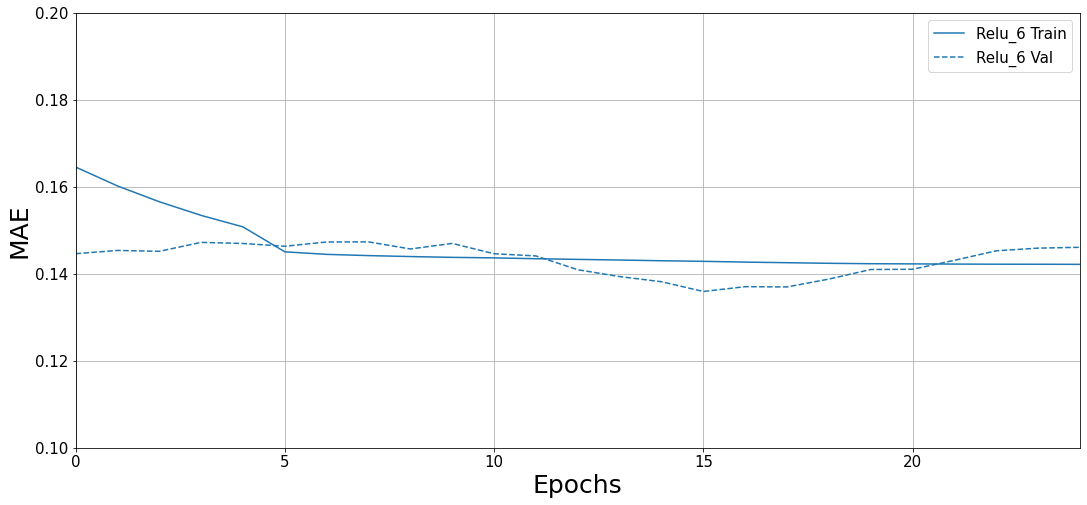

In [47]:
histories['ReLU_6'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.2])
plt.ylabel('MAE')

In [48]:
nsize = 8
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1481,  mae:0.2112,  mse:0.1481,  val_loss:0.0992,  val_mae:0.1619,  val_mse:0.0992,  
.........................

Text(0, 0.5, 'MAE')

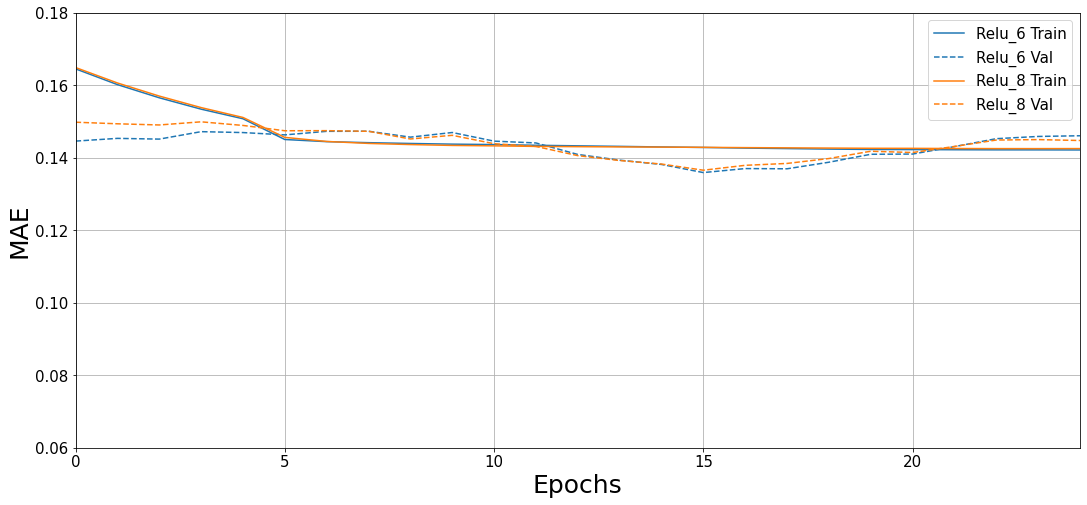

In [49]:
histories['ReLU_8'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.18])
plt.ylabel('MAE')

In [50]:
nsize = 16
activ = "ReLU"
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1280,  mae:0.1762,  mse:0.1280,  val_loss:0.0994,  val_mae:0.1900,  val_mse:0.0994,  
...........

Text(0, 0.5, 'MAE')

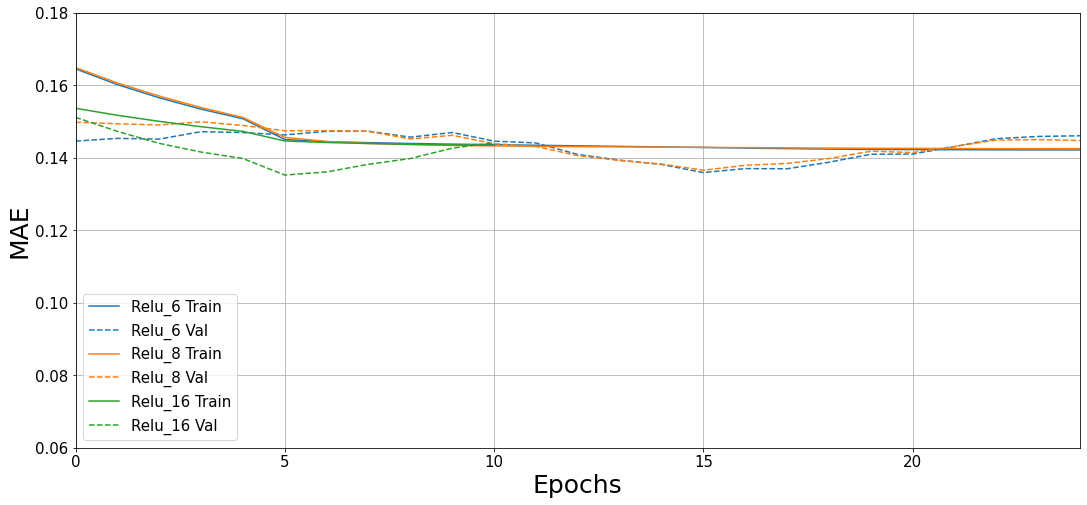

In [51]:
histories['ReLU_16'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.18])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

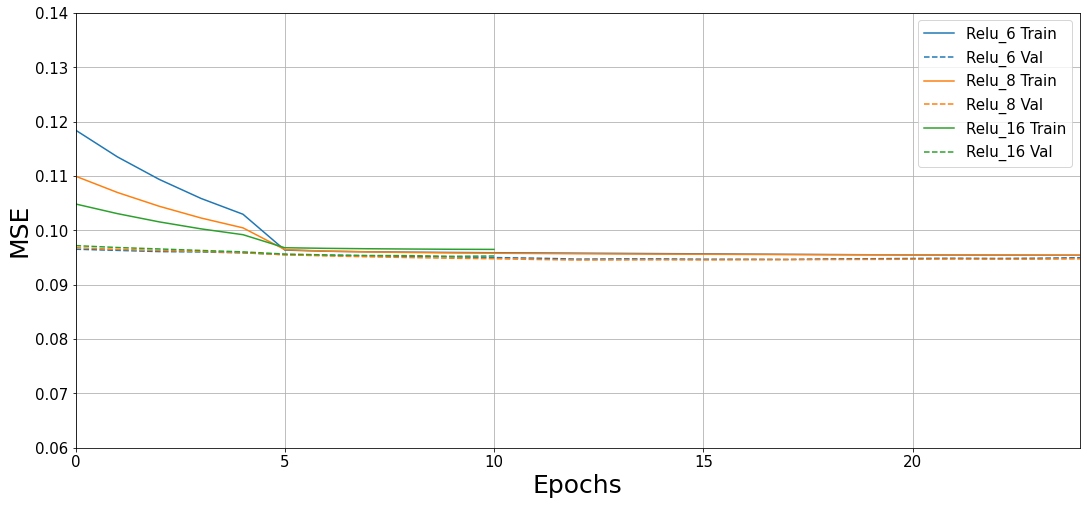

In [52]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.06, 0.14])
plt.ylabel('MSE')

In [53]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:20.5f}".format(mae1))

14288/14288 - 0s - loss: 0.0987 - mae: 0.1387 - mse: 0.0987
Testing set for model 1, Mean Abs Error:              0.13872


In [54]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

14288/14288 - 0s - loss: 0.0989 - mae: 0.1411 - mse: 0.0989
Testing set for model 2, Mean Abs Error:              0.14113


In [55]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

14288/14288 - 0s - loss: 0.0993 - mae: 0.1393 - mse: 0.0993
Testing set for model 3, Mean Abs Error:              0.13929


In [56]:
mae = [ mae1, mae2, mae3 ]
mae

[0.1387248, 0.14112544, 0.13929448]

In [57]:
mse = [ mse1, mse2, mse3 ]
mse

[0.09872994, 0.09894366, 0.0993417]

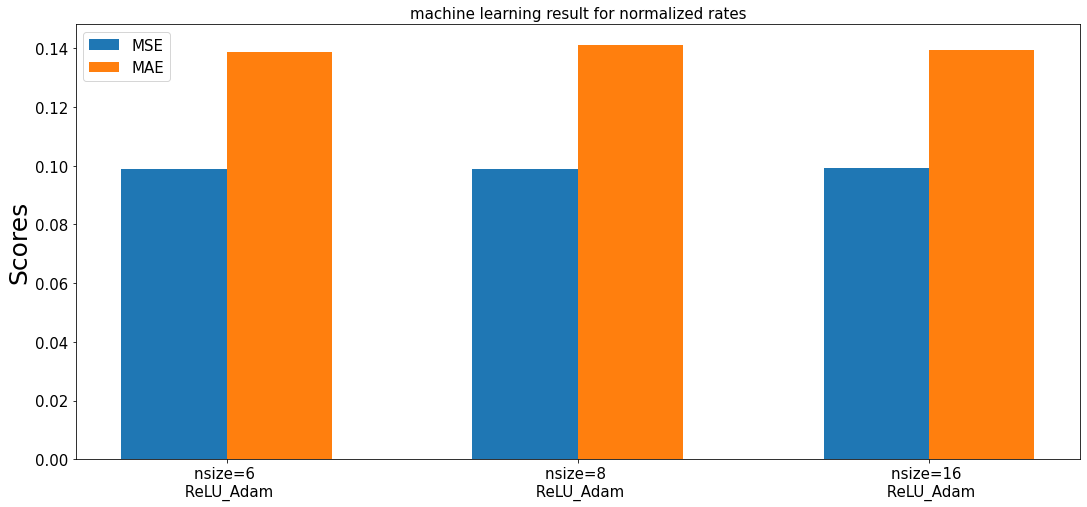

In [58]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'nsize=6 \n ReLU_Adam',
 'nsize=8 \n ReLU_Adam',
 'nsize=16 \n ReLU_Adam',]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [59]:
test_true_mass  = np.exp(test_labels.pop('depo_mass'))

In [60]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [61]:
labels = [ "depo_mass" ]

p1 = pd.DataFrame(data=model1.predict(normed_test_data2), columns=labels)

In [62]:
test_predict1 = backtransform(p1,train_labels_stats)

In [63]:
test_predict1.describe()

depo_mass
count  14288.000000
mean     -15.254298
std        2.251096
min      -23.797403
25%      -16.735704
50%      -15.250208
75%      -13.581021
max       -8.496015

In [64]:
test_predict1_mass  = np.exp(test_predict1['depo_mass'])

In [65]:
p2 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

test_predict2 = backtransform(p2,train_labels_stats)

test_predict2_mass = np.exp(test_predict2['depo_mass'])

In [66]:
p4 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict4 = backtransform(p4,train_labels_stats)

test_predict4_mass = np.exp(test_predict4['depo_mass'])

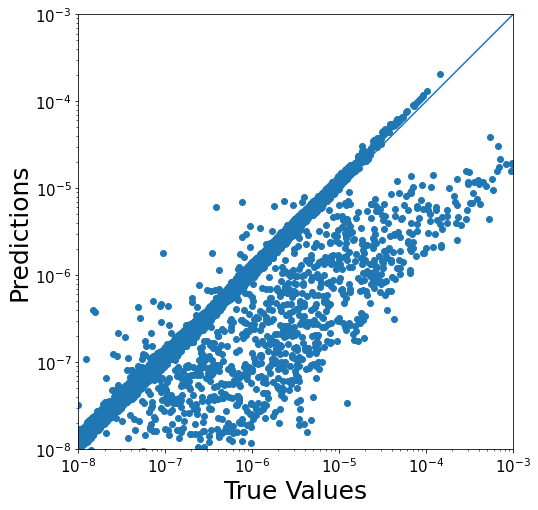

In [67]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-8, 1e-3
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

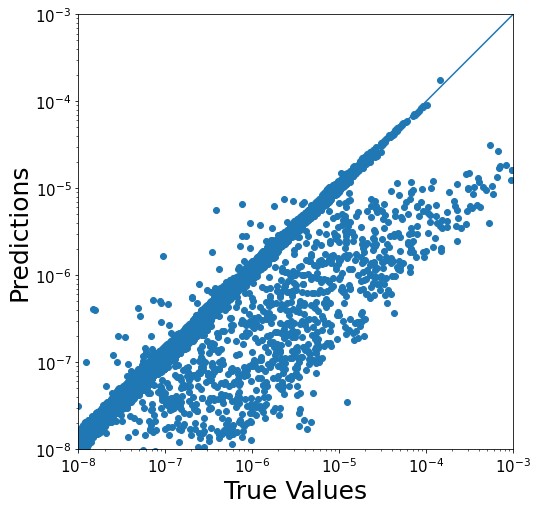

In [68]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [69]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'21'

In [70]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, labels_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["out_logtransform"] = xr.DataArray(labels_ltf, dims=("Nout_{}".format(nout)))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [71]:
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, T, rho'
logtransformInput  = np.array([True, True, True, True, False, False], dtype=bool)

labels   = 'depo_rimedice_mass'
logtransformOutput = np.array([True], dtype=bool)

filename = 'saved_model_v2/depo_rimedice_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

filename = 'saved_model_v2/depo_rimedice_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

filename = 'saved_model_v2/depo_rimedice_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

Saving model to saved_model_v2/depo_rimedice_model1_21.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, T, rho
  Labels:     depo_rimedice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 6), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 6), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 1), Activation: linear
Saving model to saved_model_v2/depo_rimedice_model2_21.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, T, rho
  Labels:     depo_rimedice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/depo_rimedice_model3_21.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, T